In [ ]:
pip install tensorflow tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 15.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sovitrath/diabetic-retinopathy-224x224-2019-data")

print("Path to dataset files:", path)

100%|██████████| 238M/238M [00:02<00:00, 85.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4


In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'../root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

In [ ]:
#create directories for train, val and test. update it everytime the code runs with shutil.rmtree
base_dir = '.\dataset'

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

#make directories for train, val and test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

valid_types = ['No_DR', 'Mild', 'Moderate', 'Severe', 'Proliferate_DR']
df = df[df['type'].isin(valid_types)]
assert all(train['type'].isin(valid_types))
assert all(val['type'].isin(valid_types))
assert all(test['type'].isin(valid_types))

In [ ]:
src_dir = r'../root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4/colored_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    if os.path.exists(srcfile):
      shutil.copy(srcfile, dstfile)
for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)
for subdir in [train_dir, val_dir, test_dir]:
  print(f"\nContents of {subdir}:")
  for root, dirs, files in os.walk(subdir):
      print(f"{root}: {len(files)} files")


Contents of .\dataset/train:
.\dataset/train: 0 files
.\dataset/train/Moderate: 699 files
.\dataset/train/Mild: 258 files
.\dataset/train/Severe: 135 files
.\dataset/train/Proliferate_DR: 207 files
.\dataset/train/No_DR: 1263 files

Contents of .\dataset/val:
.\dataset/val: 0 files
.\dataset/val/Moderate: 150 files
.\dataset/val/Mild: 56 files
.\dataset/val/Severe: 29 files
.\dataset/val/Proliferate_DR: 44 files
.\dataset/val/No_DR: 271 files

Contents of .\dataset/test:
.\dataset/test: 0 files
.\dataset/test/Moderate: 150 files
.\dataset/test/Mild: 56 files
.\dataset/test/Severe: 29 files
.\dataset/test/Proliferate_DR: 44 files
.\dataset/test/No_DR: 271 files


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size for ViT
IMG_SIZE = 224

# ImageDataGenerator for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_batches = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

val_batches = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)

test_batches = val_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical'
)


Found 2562 images belonging to 5 classes.
Found 550 images belonging to 5 classes.
Found 550 images belonging to 5 classes.


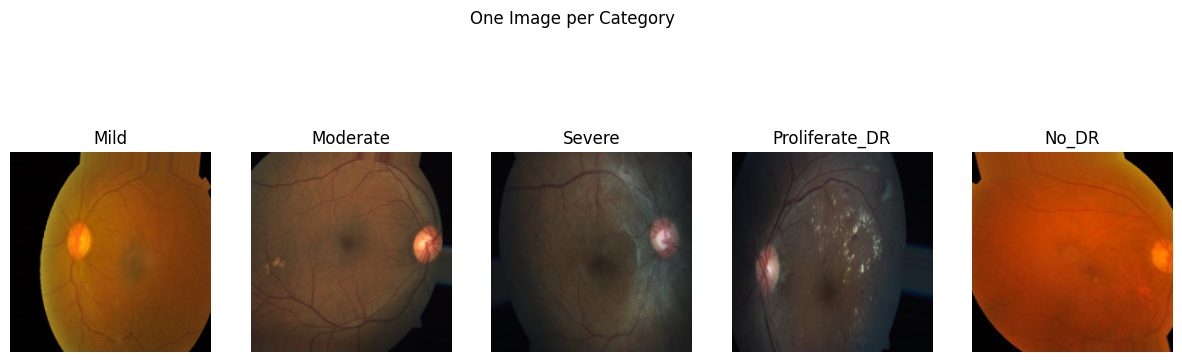

FileNotFoundError: Cannot find file: DR image.png

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize a dictionary to store one image per category
category_images = {}

# Iterate through batches until we have one image for each category
for images, labels in train_batches:
    for img, label in zip(images, labels):
        # Get the category index
        category = np.argmax(label)
        # Check if this category is already collected
        if category not in category_images:
            category_images[category] = img
        # Stop once we have one image for each category
        if len(category_images) == len(diagnosis_dict):
            break
    if len(category_images) == len(diagnosis_dict):
        break

# Plot the images
plt.figure(figsize=(15, 5))
for i, (category, img) in enumerate(category_images.items()):
    plt.subplot(1, len(diagnosis_dict), i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(diagnosis_dict[category])
plt.suptitle("One Image per Category")
plt.savefig('DR images.png')
plt.show()




In [ ]:
from google.colab import files
files.download('DR images.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)  # Use training here
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)  # Use training here
        return self.layernorm2(out1 + ffn_output)



In [ ]:
from tensorflow.keras.layers import Embedding, Dense, Conv2D, Reshape, Dropout, GlobalAveragePooling1D



class PatchEncoder(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = Dense(embed_dim)
        self.position_embedding = Embedding(input_dim=num_patches, output_dim=embed_dim)

    def call(self, patch, training=None):
      positions = tf.range(start=0, limit=self.num_patches, delta=1)
      return self.projection(patch) + self.position_embedding(positions)



In [ ]:

def build_vit(input_shape=(224, 224, 3), num_classes=5, patch_size=16, num_patches=196):
    inputs = layers.Input(shape=input_shape)

    # Create patches
    patches = layers.Conv2D(filters=64, kernel_size=patch_size, strides=patch_size, padding="valid")(inputs)
    patches = layers.Reshape((num_patches, -1))(patches)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches=num_patches, embed_dim=64)(patches)

    # Add Transformer blocks
    for _ in range(4):
        encoded_patches = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=128)(encoded_patches)

    # Classification head
    representation = layers.GlobalAveragePooling1D()(encoded_patches)
    representation = layers.Dropout(0.1)(representation)
    representation = layers.Dense(64, activation="relu")(representation)
    representation = layers.Dropout(0.1)(representation)
    outputs = layers.Dense(num_classes, activation="softmax")(representation)

    return tf.keras.Model(inputs=inputs, outputs=outputs)



In [ ]:
model = build_vit(input_shape=(224, 224, 3), num_classes=5)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=val_batches
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


81/81 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4676 - loss: 1.3611 - val_accuracy: 0.4927 - val_loss: 1.2127
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - accuracy: 0.4858 - loss: 1.2580 - val_accuracy: 0.5418 - val_loss: 1.2067
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.4666 - loss: 1.2626 - val_accuracy: 0.4982 - val_loss: 1.1438
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.5407 - loss: 1.1442 - val_accuracy: 0.6636 - val_loss: 0.8960
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.6381 - loss: 0.9434 - val_accuracy: 0.6782 - val_loss: 0.8757
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 193s 2s/step - accuracy: 0.6884 - loss: 0.8699 - val_accuracy: 0.7255 - val_loss: 0.7761
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6989 - loss: 0.8506 - val_accuracy: 0.7109 - val_loss: 0.8191
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.6962 - loss: 0.8391 - val_accuracy: 0.7036 - val_loss: 0.

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 665ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7140 - loss: 0.8105 - val_accuracy: 0.7291 - val_loss: 0.7718
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 677ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.7022 - loss: 0.7968 - val_accuracy: 0.7200 - val_loss: 0.7665
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 678ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7098 - loss: 0.8147 - val_accuracy: 0.7236 - val_loss: 0.7663
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 11s 619ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy: 0.7223 - loss: 0.7740 - val_accuracy: 0.7218 - val_loss: 0.7744
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 654ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7039 - loss: 0.8199 - val_accuracy: 0.7182 - val_loss: 0.7652
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 677ms/step
81/81 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.7263 - loss: 0.7648 - val_accuracy: 0.7255 - val

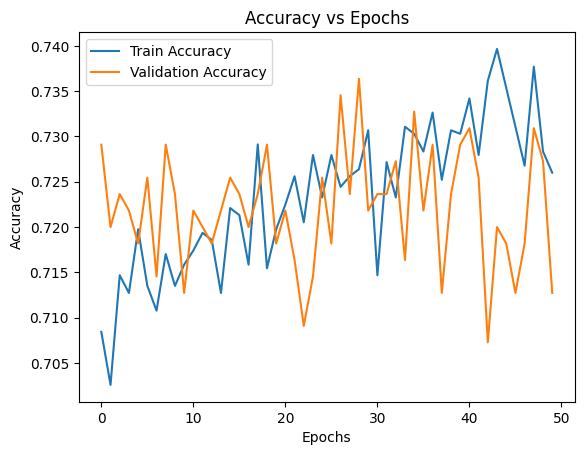

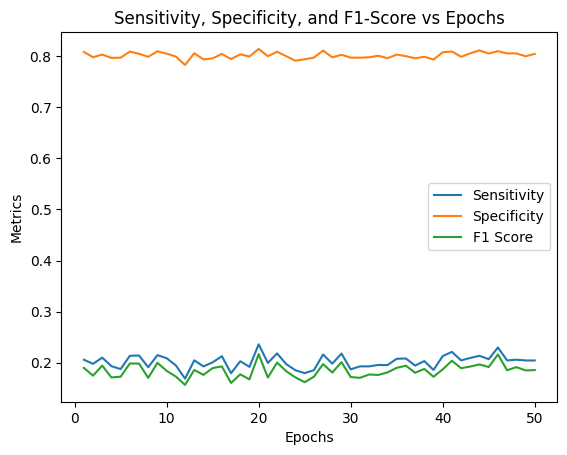

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Custom Callback to compute metrics after each epoch
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_batches):
        self.val_batches = validation_batches
        self.sensitivity = []
        self.specificity = []
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # Get predictions and ground truths
        y_pred_probs = self.model.predict(self.val_batches)  # Probabilities
        y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes
        y_true = self.val_batches.labels  # True labels

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        tp = np.diag(cm)  # True positives for each class
        fp = np.sum(cm, axis=0) - tp  # False positives for each class
        fn = np.sum(cm, axis=1) - tp  # False negatives for each class
        tn = np.sum(cm) - (tp + fp + fn)  # True negatives for each class

        # Avoid division by zero
        recall = tp / (tp + fn + np.finfo(float).eps)  # Sensitivity (Recall)
        specificity = tn / (tn + fp + np.finfo(float).eps)
        precision = tp / (tp + fp + np.finfo(float).eps)
        f1 = 2 * (precision * recall) / (precision + recall + np.finfo(float).eps)

        # Store averages across classes
        self.sensitivity.append(np.mean(recall))
        self.specificity.append(np.mean(specificity))
        self.f1_scores.append(np.mean(f1))

# Initialize callback
metrics_callback = MetricsCallback(validation_batches=val_batches)

# Train the model with the callback
history = model.fit(train_batches,
                    epochs=50,
                    validation_data=val_batches,
                    callbacks=[metrics_callback])

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.savefig('vit acc vs epoc.png')
plt.show()

# Plot Sensitivity, Specificity, and F1-score
epochs = range(1, len(metrics_callback.sensitivity) + 1)
plt.plot(epochs, metrics_callback.sensitivity, label='Sensitivity')
plt.plot(epochs, metrics_callback.specificity, label='Specificity')
plt.plot(epochs, metrics_callback.f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Sensitivity, Specificity, and F1-Score vs Epochs')
plt.legend()
plt.savefig('vit sens spec f1.png')
plt.show()

In [ ]:
files.download('vit acc vs epoc.png')
files.download('vit sens spec f1.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 779ms/step - accuracy: 0.6788 - loss: 0.8523
Test Accuracy: 70.91%
18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 636ms/step


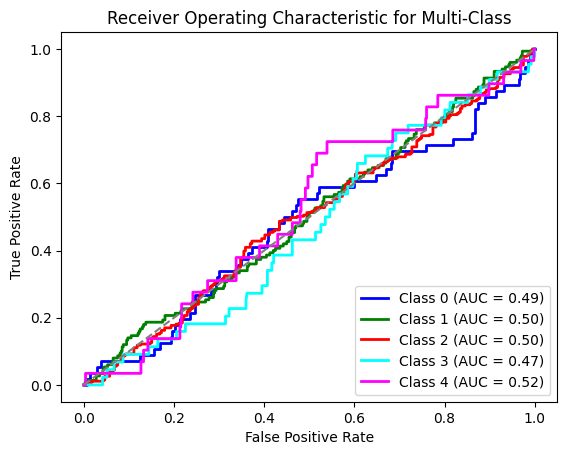

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_test = test_batches.labels  # Get the true labels
# Binarize the output (e.g., for 5 classes)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]  # Number of classes

# Ensure predictions are also in the right shape
y_pred_probs = model.predict(test_batches)  # Probabilities for all classes

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'green', 'red', 'cyan', 'magenta']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Add random guess line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc='lower right')
plt.savefig('vit roc curve.png')
plt.show()

In [ ]:
from google.colab import files
files.download('vit roc curve.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

          Mild       0.14      0.02      0.03        56
      Moderate       0.27      0.44      0.33       150
         No_DR       0.49      0.54      0.51       271
Proliferate_DR       0.00      0.00      0.00        44
        Severe       0.00      0.00      0.00        29

      accuracy                           0.39       550
     macro avg       0.18      0.20      0.18       550
  weighted avg       0.33      0.39      0.35       550



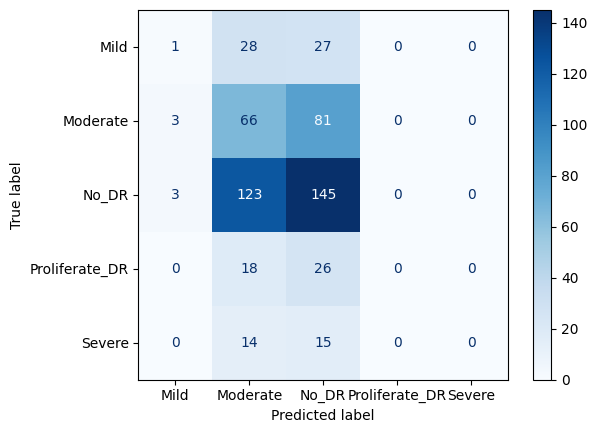

In [ ]:
from sklearn.metrics import classification_report
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted class labels
print(classification_report(y_test, y_pred, target_names=test_batches.class_indices.keys()))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_batches.class_indices.keys())
disp.plot(cmap="Blues")
plt.savefig('vit conmat.png')
plt.show()



In [ ]:
from google.colab import files
files.download('vit conmat.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_loss, test_accuracy = model.evaluate(test_batches)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step - accuracy: 0.7363 - loss: 0.7401
Test Accuracy: 71.82%


In [ ]:
from math import ceil, pow
src_dir = r'../root/.cache/kagglehub/datasets/sovitrath/diabetic-retinopathy-224x224-2019-data/versions/4/colored_images'
for i in range(5):
  total_files = len(train)
  denom = pow(2, i)
  print(denom)
  files_to_copy = ceil(total_files / denom)  # Half the files, rounded up if odd
  print(files_to_copy)

  if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
  os.makedirs(train_dir, exist_ok=True)

  # Counter to track the number of files copied
  copied_files = 0

  for index, row in train.iterrows():
    if copied_files >= files_to_copy:
        break  # Stop when half of the files are copied

    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)

    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)
        copied_files += 1  # Increment the counter

  for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)

  for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok=True)
    if os.path.exists(srcfile):
        shutil.copy(srcfile, dstfile)





  for subdir in [train_dir, val_dir, test_dir]:
    print(f"\nContents of {subdir}:")
    for root, dirs, files in os.walk(subdir):
        print(f"{root}: {len(files)} files")

  train_path = train_dir
  val_path = val_dir
  test_path = test_dir

  from tensorflow.keras.preprocessing.image import ImageDataGenerator

  # Define image size for ViT
  IMG_SIZE = 224

  # ImageDataGenerator for preprocessing and augmentation
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
  )

  val_datagen = ImageDataGenerator(rescale=1./255)

  train_batches = train_datagen.flow_from_directory(
      train_dir,
      target_size=(IMG_SIZE, IMG_SIZE),
      batch_size=32,
      class_mode='categorical'
  )

  val_batches = val_datagen.flow_from_directory(
      val_dir,
      target_size=(IMG_SIZE, IMG_SIZE),
      batch_size=32,
      class_mode='categorical'
  )

  test_batches = val_datagen.flow_from_directory(
      test_dir,
      target_size=(IMG_SIZE, IMG_SIZE),
      batch_size=32,
      class_mode='categorical'
  )

  model = build_vit(input_shape=(224, 224, 3), num_classes=2)


  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  history = model.fit(
    train_batches,
    epochs=10,
    validation_data=val_batches
  )

1.0
2562

Contents of .\dataset/train:
.\dataset/train: 0 files
.\dataset/train/No_DR: 1263 files
.\dataset/train/DR: 1299 files

Contents of .\dataset/val:
.\dataset/val: 0 files
.\dataset/val/No_DR: 271 files
.\dataset/val/DR: 279 files

Contents of .\dataset/test:
.\dataset/test: 0 files
.\dataset/test/No_DR: 271 files
.\dataset/test/DR: 279 files
Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.5473 - loss: 0.6990 - val_accuracy: 0.5236 - val_loss: 0.6295
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6094 - loss: 0.6367 - val_accuracy: 0.6527 - val_loss: 0.5635
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6892 - loss: 0.5631 - val_accuracy: 0.8673 - val_loss: 0.2989
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.8897 - loss: 0.2919 - val_accuracy: 0.9418 - val_loss: 0.2133
Epoch 5/10
81/8

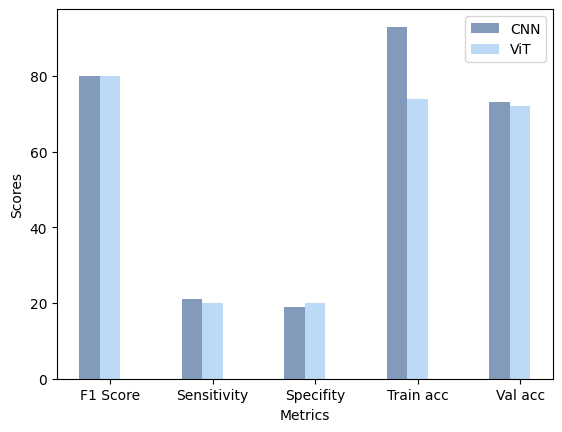

In [ ]:
# create data
x = np.arange(5)
y1 = [80, 21, 19, 93, 73]
y2 = [80, 20, 20, 74, 72]

width = 0.2

# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='#849abb')
plt.bar(x, y2, width, color='#bcdaf5')

plt.xticks(x, ['F1 Score', 'Sensitivity', 'Specifity', 'Train acc', 'Val acc'])
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.legend(["CNN", "ViT"])
plt.savefig("CNN vs ViT Comparison.png")
plt.show()

In [ ]:
from google.colab import files
files.download('CNN vs ViT Comparison.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>